<a href="https://colab.research.google.com/github/nimish1402/Potato-Disease-Classification-/blob/main/potato_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/PlantVillage.zip")
zip_ref.extractall('/content')
zip_ref.close()

Importing the essential libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np


#**Step 1 - Data Gathering**

In [ ]:
# defining the constants
IMG_SIZE = 256
BATCH_SIZE=32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    shuffle =True,
    image_size = (IMG_SIZE , IMG_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)
# its giving output 68 cuz every element is in a batch of 32
# therefore , 32*68 = approx 2152(total images)

68

(32, 256, 256, 3)
[1 0 0 1 1 0 1 0 1 0 0 1 0 2 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1]
(256, 256, 3)


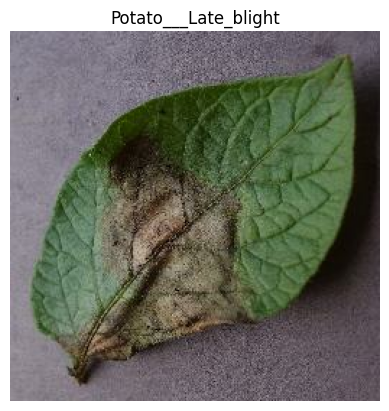

In [ ]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch.shape)
  # output - (batch_size, px , px , channels(RGB))
  print(label_batch.numpy())
  # printing the first image as a numpy array
  print(image_batch[0].shape)

  # visualizing the image
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  # getting the image label as the class name
  plt.title(class_names[label_batch[0]])
  plt.axis("off")

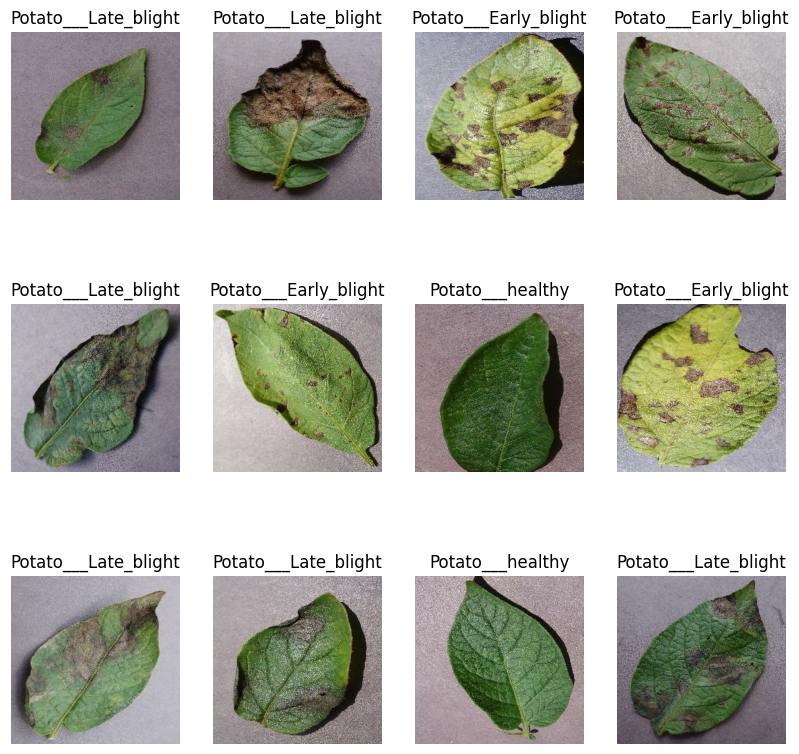

In [ ]:
# displaying couple of images from batch one
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

#splitting the dataset into train and test

In [ ]:
# 80% -> training dataset
# 10% -> validation set
# 10% -> test set

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitons_tf(ds, train_split = 0.8, val_split=0.1,test_ds=0.1,shuffle =True , shuffle_size = 10000 ):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size , seed = 12)

  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds , val_ds, test_ds

In [ ]:
# calling the function on to the dataset

get_dataset_partitons_tf(dataset)

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
# cacheing the dataset -> this will read the image from the data and keep it in the memory for next iteration
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#**Step - 2 Data Preprocessing**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
# after applying this layer we will introduce one more layer to make our model robust i.e. we will apply filters roatate the same image which will give us the 4-5 images from the single image


**After applying this layer we will introduce one more layer to make our model robust i.e. we will apply filters roatate the same image which will give us the 4-5 images from the single image**


In [ ]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#**Step -3 Building CNN Model**

**model architecture**


In [ ]:
input_shape=(BATCH_SIZE , IMG_SIZE, IMG_SIZE , CHANNELS)
model = models.Sequential([
    resize_and_rescale ,
    data_augumentation,
    layers.Conv2D(32, (3,3), activation='relu',input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,  kernel_size =(3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,  kernel_size =(3,3),activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(3 , activation ='softmax'),
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 16s 95ms/step - loss: 0.8722 - accuracy: 0.5405 - val_loss: 0.6303 - val_accuracy: 0.7448
Epoch 2/50
54/54 [==============================] - 3s 64ms/step - loss: 0.5373 - accuracy: 0.7564 - val_loss: 0.3314 - val_accuracy: 0.8594
Epoch 3/50
54/54 [==============================] - 3s 62ms/step - loss: 0.3012 - accuracy: 0.8843 - val_loss: 0.4181 - val_accuracy: 0.8229
Epoch 4/50
54/54 [==============================] - 3s 63ms/step - loss: 0.2746 - accuracy: 0.8837 - val_loss: 0.3542 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 3s 63ms/step - loss: 0.2363 - accuracy: 0.8993 - val_loss: 0.1949 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 3s 63ms/step - loss: 0.1912 - accuracy: 0.9201 - val_loss: 0.2953 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 3s 63ms/step - loss: 0.2044 - accuracy: 0.9242 - val_loss: 0.2888 - val_accuracy: 0.8802
Epoch 8/50
5

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
# gives the history of accuracy from first epoch to the last
history.history['accuracy']

[0.5405092835426331,
 0.7563657164573669,
 0.8842592835426331,
 0.8836805820465088,
 0.8993055820465088,
 0.9201388955116272,
 0.9241898059844971,
 0.9259259104728699,
 0.9340277910232544,
 0.9421296119689941,
 0.9473379850387573,
 0.9380787014961243,
 0.9450231194496155,
 0.9623842835426331,
 0.9537037014961243,
 0.9554398059844971,
 0.9641203880310059,
 0.9583333134651184,
 0.9537037014961243,
 0.9699074029922485,
 0.9733796119689941,
 0.9641203880310059,
 0.9756944179534912,
 0.9837962985038757,
 0.9803240895271301,
 0.9895833134651184,
 0.9837962985038757,
 0.984375,
 0.9716435074806213,
 0.9855324029922485,
 0.9861111044883728,
 0.9751157164573669,
 0.9884259104728699,
 0.9861111044883728,
 0.9872685074806213,
 0.9913194179534912,
 0.9924768805503845,
 0.984375,
 0.9907407164573669,
 0.9837962985038757,
 0.9890046119689941,
 0.9965277910232544,
 0.984375,
 0.9907407164573669,
 0.9924768805503845,
 0.9930555820465088,
 0.9832175970077515,
 0.9930555820465088,
 0.9953703880310059,
 

**plotting the various scores**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

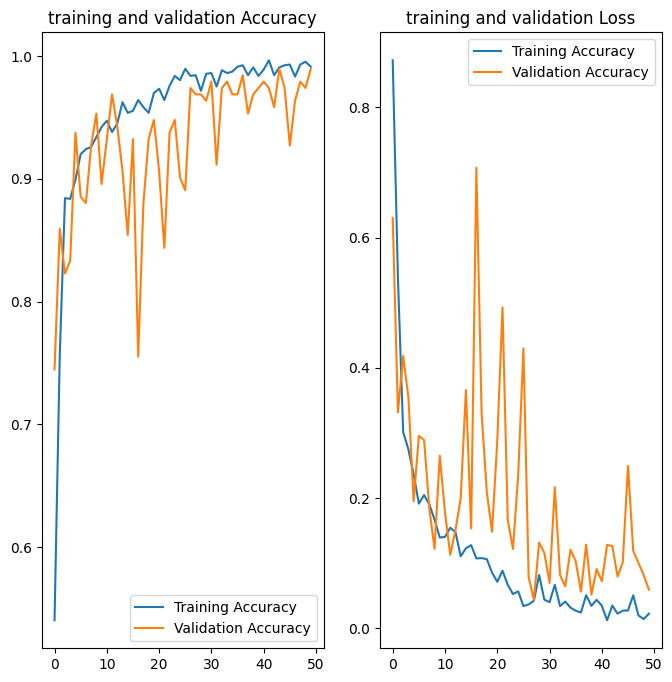

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('training and validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('training and validation Loss')
plt.show()

#step -4 Model Evaluation

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 79ms/step - loss: 0.0489 - accuracy: 0.9914


In [ ]:
scores
# this shows the python list whose first parameter is loss and second one is the accuracy

[0.04891064390540123, 0.9913793206214905]

# step -5 Prediction

the first image to predict
first image's actual label:  Potato___Early_blight
1/1 [==============================] - 0s 39ms/step
predicted_label:  Potato___Early_blight


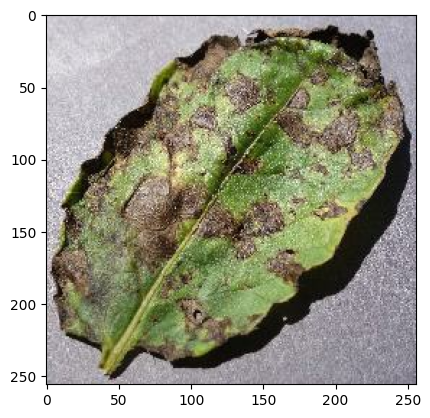

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("the first image to predict")
  plt.imshow(first_image)
  print("first image's actual label: ",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted_label: " , class_names[np.argmax(batch_prediction[0])])

**model preforming exceptionally well no overfitting and good accuracy achieved**

**creating a function for prediction**

In [ ]:
def predict(model , img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)   #creating a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class , confidence

In [ ]:
# running the prediction on the entire batch

1/1 [==============================] - 0s 17ms/step


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

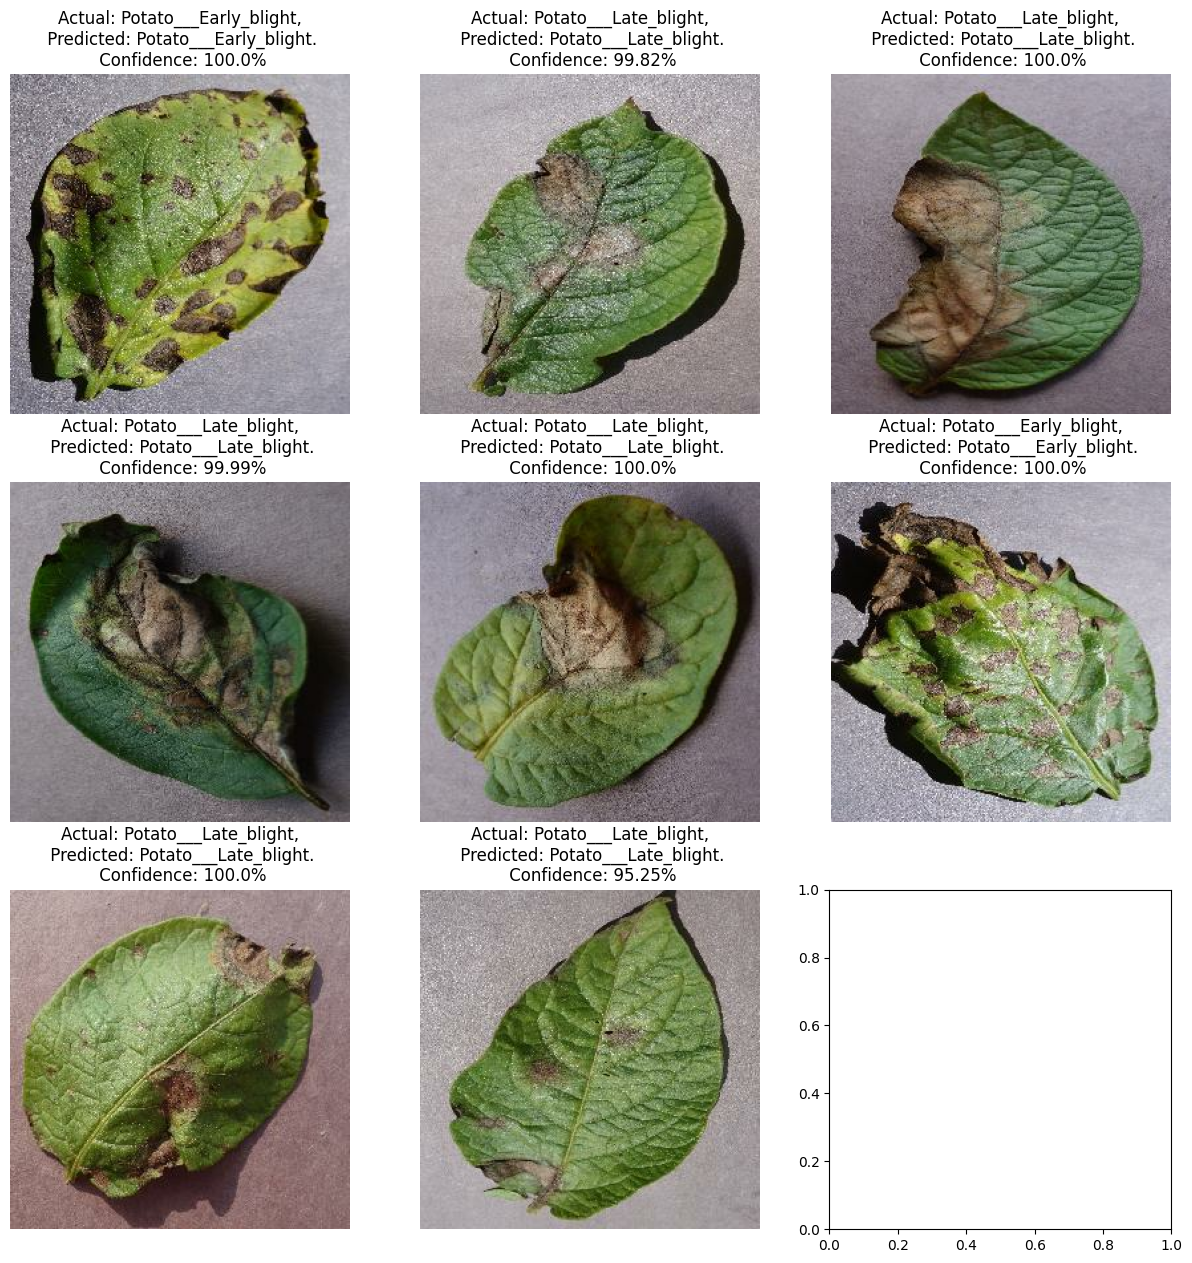

In [ ]:
plt.figure(figsize=(15,15))
for images , labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))


    predicted_class , confidence = predict(model , images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")